In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# pip install catboost

### Import and constants

In [ ]:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format
# import datetime
import os
from tqdm import tqdm
import pickle
import multiprocessing
import warnings

# from joblib import dump, load
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [ ]:
from sklearn.linear_model import ElasticNet, Ridge, Lasso, SGDRegressor
import lightgbm as lgb
import xgboost as xgb
from catboost import Pool, CatBoostRegressor

from sklearn.preprocessing import PowerTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor

from sklearn.metrics import mean_absolute_error

from hyperopt import hp, fmin, tpe, rand, Trials, STATUS_OK
from scipy import stats
import statsmodels.api as sm
from itertools import product

import holidays

In [ ]:
PATH_TO_DATA = '/content/drive/MyDrive/Colab Notebooks/taxi/'
# PATH_TO_DATA = '/mnt/e/GoogleDrive/Colab Notebooks/taxi/'
LONG = [-74.25559, -73.70001]
LAT = [40.49612, 40.91553]
RANDOM_STATE = 30
START_DATE = '2015-03'
MAX_TRAIN_TIME = '2016-04'

### Helpers

In [ ]:
def load_pickles(start, end, zone):
    """
    format YYYY-MM, start included, end - not
    """
    res = pd.DataFrame()
    for d in tqdm(pd.date_range(start, end, freq='M')):
        with open(os.path.join(PATH_TO_DATA, f'pickles/yellow_tripdata_{d.year}-{d.month:02}.pkl'), 'rb') as f:
            df = pickle.load(f)
            #print(type(df[zone]))
        res = res.append(df[zone])
    return res

In [ ]:
def add_feature(data, K=[15], names=['W'], seasons=[168], trend = False):
    T = data.shape[0]
    if type(seasons) == int: seasons = [seasons]
    if type(K) == int: K = [K]
    if len(seasons) != len(K): return '# of seasons and # of K must be equal'
    res=np.empty((T, 2*sum(K)+trend))
    for i, season in enumerate(seasons):
        k=K[i]
        prev = 2*sum(K[:i])
        arr = 2 * np.pi * np.outer(np.arange(1, T+1), np.arange(1, k+1)) / season
        res[:, prev: prev+k] = np.sin(arr)
        res[:, prev+k:prev+2*k] = np.cos(arr)
    if trend: res[:, -1] = np.arange(1, T+1)
    columns = [f'{name}_{f}_{j}' for i, name in enumerate(names) for f in ['sin', 'cos'] for j in range(1, K[i]+1)]
    if trend: columns += ['trend']
    res = pd.DataFrame(res, index=data.index, columns=columns)
    return res

In [ ]:
def add_holidays(y):
    holidays_NY = holidays.CountryHoliday('US', state='NY', years=[2015, 2016])
    holidays_NY = pd.Series(holidays_NY.values(), index=holidays_NY.keys()).sort_index()
    holidays_NY.index = pd.to_datetime(holidays_NY.index)
    holidays_NY = holidays_NY.loc[y.index.min(): y.index.max()]
    res = pd.DataFrame(np.zeros((y.shape[0], holidays_NY.nunique())),
                 index=y.index, columns=holidays_NY.unique())
    for index, holiday in holidays_NY.items():
        res.loc[index.strftime('%Y-%m-%d'), holiday] = 1
    return res

# def add_holidays(y):
#     holidays_NY = holidays.CountryHoliday('US', state='NY', years=[2013, 2016])
#     holidays_NY = pd.Series(holidays_NY.values(), index=holidays_NY.keys()).sort_index()
#     holidays_NY.index = pd.to_datetime(holidays_NY.index)
#     holidays_NY = holidays_NY.loc[y.index.min(): y.index.max()]
#     columns = list(holidays_NY.unique()) + [s+'_ba' for s in holidays_NY.unique()]
#     res = pd.DataFrame(np.zeros((y.shape[0], 2*holidays_NY.nunique())),
#                  index=y.index, columns=columns)
#     for index, holiday in holidays_NY.items():
#         res.loc[index.strftime('%Y-%m-%d'), holiday] = 1
#         before = (index - pd.Timedelta('1d')).strftime('%Y-%m-%d')
#         after = (index + pd.Timedelta('1d')).strftime(`'%Y-%m-%d')
#         res.loc[before, holiday+'_ba'] = 1
#     return res

In [ ]:
def load_model_data(model, v='norm', one_hot=False): # model 1..6
    X, y = [], []
    cat = 'cat_dummies' if one_hot else 'cat'
    for st in ['train', 'val', 'test']:
        x = pd.read_parquet(PATH_TO_DATA + f'regr_data/X_{st}_{v}.parquet')
        x['arima'] = pd.read_parquet(PATH_TO_DATA + f'regr_data/arima_{st}_{v}.parquet',
                                        columns=[f'arima_{model}']).values
        cat_features = pd.read_parquet(PATH_TO_DATA + f'regr_data/{cat}_{st}.parquet')
        y.append(pd.read_parquet(PATH_TO_DATA + f'regr_data/y_{st}.parquet',
                            columns=[f'y_{model}']).values.squeeze())
        X.append(pd.concat([cat_features, x], axis=1))
        
    return X[0], y[0], X[1], y[1], X[2], y[2]

In [ ]:
def load_model_data_(model, v='norm', one_hot=False): # model 1..6
    X, y = [], []
    cat = 'cat_dummies' if one_hot else 'cat'
    for st in ['train', 'val', 'test']:
        x = pd.read_parquet(PATH_TO_DATA + f'regr_data_/X_{st}_{v}.parquet')
        x['arima'] = pd.read_parquet(PATH_TO_DATA + f'regr_data_/arima_{st}_{v}.parquet',
                                        columns=[f'arima_{model}']).values
        y.append(pd.read_parquet(PATH_TO_DATA + f'regr_data_/y_{st}.parquet',
                            columns=[f'y_{model}']).values.squeeze())
        X.append(x)
        
    return X[0], y[0], X[1], y[1], X[2], y[2]

### Data load and preprocessing

In [ ]:
with open(PATH_TO_DATA+'selected_regions.pkl', 'rb') as f:
    selected_regions = pickle.load(f)

In [ ]:
zones = selected_regions.to_list()
data = load_pickles(START_DATE, '2016-07', zones).astype(np.int16)

In [ ]:
data.info()

### Регрессионные признаки

Создаем блок признаков, одинаковый для всех зон. Столбец 'zone' резервируем под номер зоны.

In [ ]:
# add categorical feature
cat_features = pd.DataFrame()
cat_features['year'] = data.index.year
cat_features['month'] = data.index.month
cat_features['day'] = data.index.day
cat_features['weekday'] = data.index.weekday
cat_features['hour'] = data.index.hour
cat_features.index = data.index
cat_features['zone'] = 0
columns_cat = cat_features.columns.to_list()

# add sin/cos and trend
cat_features = cat_features.join(add_feature(data, [2, 6], ['D', 'W'], [24, 168]))
# cat_features = cat_features.join(add_feature(data, [2, 6, 2], ['D', 'W', 'Y'], [24, 168, 8766]))
cat_features[:3]

,year,month,day,weekday,hour,zone,D_sin_1,D_sin_2,D_cos_1,D_cos_2,W_sin_1,W_sin_2,W_sin_3,W_sin_4,W_sin_5,W_sin_6,W_cos_1,W_cos_2,W_cos_3,W_cos_4,W_cos_5,W_cos_6
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,,
2015-03-01 00:00:00,2015,3,1,6,0,0,0.259,0.500,0.966,0.866,0.037,0.075,0.112,0.149,0.186,0.223,0.999,0.997,0.994,0.989,0.983,0.975
2015-03-01 01:00:00,2015,3,1,6,1,0,0.500,0.866,0.866,0.500,0.075,0.149,0.223,0.295,0.365,0.434,0.997,0.989,0.975,0.956,0.931,0.901
2015-03-01 02:00:00,2015,3,1,6,2,0,0.707,1.000,0.707,0.000,0.112,0.223,0.330,0.434,0.532,0.623,0.994,0.975,0.944,0.901,0.847,0.782


Добавляем признаки, полученные из колличества поездок для каждой зоны. Также добавляем предсказания модели SARIMAX из прошлой недели и значение целевого признака 'y' со здвигом от 1 до 6 дней. 
Создадим отдельный DataFrame из категориальных признаков, кодированных с помощью get_dummies.

In [ ]:
%%time
# add rides shifted for 1..K houres, 1..Kd days, sum ...
K, Kd = 6, 2
df = pd.DataFrame()
for col in data:
    ddf = cat_features.copy()
    ddf['zone'] = col # zone
    for i in range(1, K+1):
        ddf[f'hourAgo_{i}'] = data[col].shift(i)
    for i in range(1, Kd+1):
        ddf[f'dayAgo_{i}'] = data[col].shift(i*24)
    ddf['sum_12H'] = data[col].rolling(12).sum()
    ddf['sum_1D'] = data[col].rolling(24).sum()
    ddf['sum_7D'] = data[col].rolling(168).sum()
    ddf['sum_30D'] = data[col].rolling(720).sum()
    
    
    # add target y_1..y_6 and predictions of ARIMA
    arima1 = pd.read_csv(PATH_TO_DATA + f'ARIMA_APR15_APR16_6h/zone_{col}.csv', parse_dates=[0], index_col=[0])
    arima2 = pd.read_csv(PATH_TO_DATA + f'ARIMA_JUNE_6h/zone_{col}.csv', parse_dates=[0], index_col=[0])
    for i in range(1, 7):
        ddf[f'y_{i}'] = data[col].shift(-i)
        ddf[f'arima_{i}'] = arima1.iloc[:, i-1]
        ddf.loc['2016-05-31 23':,f'arima_{i}'] = arima2.iloc[:, i-1]
    df = df.append(ddf)
columns_y = [f'y_{i}' for i in range(1,7)]
columns_arima = [f'arima_{i}' for i in range(1,7)]
columns_real = df.columns.difference(cat_features.columns.to_list() + columns_y + columns_arima + ['zone']).to_list()
df = df.sort_index()

cat_dummies = pd.get_dummies(df[columns_cat], columns=columns_cat)

CPU times: user 20.9 s, sys: 3.07 s, total: 23.9 s
Wall time: 1min 14s


#### Save to disk

Разбиваем данные на train, val, test. Сохраняем все в словарь датафреймов datas.

In [ ]:
slices, datas = {}, {}
stages = ['train', 'val', 'test']

slices['start_train'], slices['end_train'] = '2015-03-31 23', '2016-04-30 17'
slices['start_val'], slices['end_val'] = '2016-04-30 23', '2016-05-31 17'
slices['start_test'], slices['end_test'] = '2016-05-31 23', '2016-06-30 17'
for st in stages:
    tdf = df.loc[slices[f'start_{st}']: slices[f'end_{st}']]
    tdf[columns_y].to_parquet(PATH_TO_DATA + f'regr_data/y_{st}.parquet')
    tdf[columns_cat].to_parquet(PATH_TO_DATA + f'regr_data/cat_{st}.parquet')
    cat_dummies.loc[slices[f'start_{st}']: slices[f'end_{st}']].to_parquet(PATH_TO_DATA
                                                                           + f'regr_data/cat_dummies_{st}.parquet')
    datas[f'arima_{st}'] = tdf[columns_arima]
    datas[f'y_{st}'] = tdf[columns_y].values
    datas[f'cat_{st}'] = tdf[columns_cat].values
    datas[f'cat_dummies_{st}'] = cat_dummies.loc[slices[f'start_{st}']: slices[f'end_{st}']].values
    datas[f'X_{st}'] = tdf.drop(columns_y + columns_arima + columns_cat, axis=1)


К веществинным признакам применим стандартизацию и сохраним на диск.

In [ ]:
scaler = StandardScaler()
datas['X_train'][columns_real] = scaler.fit_transform(datas['X_train'][columns_real])
datas['X_val'][columns_real] = scaler.transform(datas['X_val'][columns_real])
datas['X_test'][columns_real] = scaler.transform(datas['X_test'][columns_real])

datas['arima_train'] = pd.DataFrame(scaler.fit_transform(datas['arima_train']), columns=columns_arima)
datas['arima_val'] = pd.DataFrame(scaler.transform(datas['arima_val']), columns=columns_arima)
datas['arima_test'] = pd.DataFrame(scaler.transform(datas['arima_test']), columns=columns_arima)

for k in datas:
    datas[k].to_parquet(PATH_TO_DATA + f'regr_data/{k}_norm.parquet')

Вещественные признаки имеют ассиметричное распределение. С помощью преобразования box-cox попробовал исправить это и использовать эти данные для моделей. Такое же преобразование применялось и к целевому признаку. Результат не оправдал надежд.

In [ ]:
scaler = PowerTransformer(standardize=True)
datas['X_train'][columns_real] = scaler.fit_transform(datas['X_train'][columns_real])
datas['X_val'][columns_real] = scaler.transform(datas['X_val'][columns_real])
datas['X_test'][columns_real] = scaler.transform(datas['X_test'][columns_real])

datas['arima_train'] = pd.DataFrame(scaler.fit_transform(datas['arima_train']), columns=columns_arima)
datas['arima_val'] = pd.DataFrame(scaler.transform(datas['arima_val']), columns=columns_arima)
datas['arima_test'] = pd.DataFrame(scaler.transform(datas['arima_test']), columns=columns_arima)

for k in datas:
    datas[k].to_parquet(PATH_TO_DATA + f'regr_data/{k}_box.parquet')

In [ ]:
pd.to_pickle(columns_real, PATH_TO_DATA + 'regr_data/columns_real.pickle')

### Models

#### Linear regression (SGDRegressor)

Нам нужна модель, устойчива к избыточному колличеству признаков. Это L1 регуляризация. Учитывая большое колличество объектов, применим SGDRegressor с L1 регуляризацией.

Для поиска гиперпараметров применим библиотеку hyperopt.

In [ ]:
def objective_sgdr(params):
    """
    Валидация с текущими гиперпараметрами

    :params: гиперпараметры
    :pipeline: модель
    :X_train, X_val: матрица признаков 
    :y_train, y_val: вектор значений объектов
    :return: 'mae' on X_val, y_val
    """ 

    # задаём модели требуемые параметры    
    model = SGDRegressor(penalty='l1', shuffle=False, random_state=99)
    model.set_params(**params)


    # обучаем модель и считаем среднюю абсолютною ошибку на данных за май
    model.fit(X_train, y_train)
    score = mean_absolute_error(y_val, model.predict(X_val))

    # возвращаем результаты, которые записываются в Trials()
    return   {'loss': score, 'params': params, 'status': STATUS_OK}

In [ ]:
# 

search_space = {'alpha': hp.uniform('alpha', low=0.01, high=0.5),
                'eta0': hp.choice('eta0', [1e-2])
                }

trials_sgdr = []

for lag in tqdm(range(1, 7)):
    # load data
    X_train, y_train, X_val, y_val, _, _ = load_model_data(lag, 'norm', True)
    # 
    trials = Trials()
    best = fmin( 
            # функция для оптимизации  
                fn=objective_sgdr,
            # пространство поиска гиперпараметров  
                space=search_space,
            # алгоритм поиска
                algo=tpe.suggest,
            # число итераций 
            # (можно ещё указать и время поиска) 
                max_evals=5,
            # куда сохранять историю поиска
                trials=trials,
            # random state
                rstate=np.random.RandomState(99),
            # progressbar
                show_progressbar=False
                )
    trials_sgdr.append(trials)
    print(f"\t\tMAE = {trials.best_trial['result']['loss']}")
print(f"\nQmay = {sum([trials.best_trial['result']['loss'] for trials in trials_sgdr]) / 6}")


 17%|█▋        | 1/6 [00:48<04:04, 48.97s/it]

		MAE = 17.55151320838835



 33%|███▎      | 2/6 [01:32<03:08, 47.24s/it]

		MAE = 21.93175746556983



 50%|█████     | 3/6 [02:14<02:17, 45.81s/it]

		MAE = 23.22219852577829



 67%|██████▋   | 4/6 [02:57<01:29, 44.85s/it]

		MAE = 23.41645148232163



 83%|████████▎ | 5/6 [03:40<00:44, 44.49s/it]

		MAE = 23.594025410443983



100%|██████████| 6/6 [04:24<00:00, 44.06s/it]

		MAE = 23.61054857649078

Qmay = 22.221082444832145


Линейная регрессия не улучшила предсказание. Попробуем модели градиентного бустинга.

#### LightGBM

С помощью hyperopt подбираем гиперпараметры и сохраняем лучшую модель на диск

In [ ]:
def objective_lgbm(params):
    """
    Валидация с текущими гиперпараметрами

    :params: гиперпараметры
    :pipeline: модель
    :X_train, X_val: матрица признаков 
    :y_train, y_val: вектор значений объектов
    :return: 'mae' on X_val, y_val
    """ 

    # задаём модели требуемые параметры
    num_round = 100000
    param = {'objective':'regression', 'lambda_l2': 0, 'lambda_l1': 0, 
             'max_bin_by_feature': ([32]*6 + [255]*28 + [1024]),
             'verbose': 0, 'random_state': 99}
    param['metric'] = ['l1']
    param.update(params)
    param['num_leaves'] = int(param['num_leaves'])
            
    # обучаем модель и считаем среднюю абсолютною ошибку на данных за май
    model = lgb.train(param, dtrain, num_round, valid_sets=[dval],
                    early_stopping_rounds=10, verbose_eval=5000)
    
    score = mean_absolute_error(y_val, model.predict(X_val))
    
    try:
        best = score < trials.best_trial['result']['loss']
    except:
        best = True
    if best: model.save_model(PATH_TO_DATA + f'models/lgbm_{lag}', num_iteration=model.best_iteration)

    # возвращаем результаты, которые записываются в Trials()
    return   {'loss': score, 'params': params, 'status': STATUS_OK}

In [ ]:
# 

warnings.filterwarnings('ignore')

search_space = {'num_leaves': hp.quniform('num_leaves', low=450, high=900, q=50),
                'max_depth': hp.choice('max_depth', [-1]), 
                # 'max_bin': hp.choice('max_bin', [255]),   
                'learning_rate': hp.uniform('learning_rate', low=0.01, high=0.05)
                }

trials_lgbm = []

for lag in tqdm(range(1, 7)):
    # load data
    X_train, y_train, X_val, y_val, _, _ = load_model_data(lag, 'norm', False)
    # make Dataset
    columns_cat=['zone']
    dtrain = lgb.Dataset(X_train, label=y_train, 
                         categorical_feature=columns_cat, free_raw_data=False)
    dval = lgb.Dataset(X_val, label=y_val, 
                       reference=dtrain, categorical_feature=columns_cat)
    # 
    trials = Trials()
    best = fmin( 
            # функция для оптимизации  
                fn=objective_lgbm,
            # пространство поиска гиперпараметров  
                space=search_space,
            # алгоритм поиска
                algo=rand.suggest,
                # algo=tpe.suggest,
            # число итераций 
            # (можно ещё указать и время поиска) 
                max_evals=5,
            # куда сохранять историю поиска
                trials=trials,
            # random state
                rstate=np.random.RandomState(99),
            # progressbar
                show_progressbar=False
                )
    trials_lgbm.append(trials)
    print(f"\t\tMAE = {trials.best_trial['result']['loss']}")
print(f"\nQmay = {sum([trials.best_trial['result']['loss'] for trials in trials_lgbm]) / 6}")

warnings.filterwarnings('default')



  0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[2195]	valid_0's l1: 13.7182
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[1335]	valid_0's l1: 13.7798
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[2090]	valid_0's l1: 13.8025
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[1185]	valid_0's l1: 13.8484
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[1042]	valid_0's l1: 13.759




 17%|█▋        | 1/6 [42:00<3:30:03, 2520.77s/it]

		MAE = 13.718193881354914
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[1693]	valid_0's l1: 15.7689
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[1312]	valid_0's l1: 15.7889
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[2548]	valid_0's l1: 15.6795
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[1275]	valid_0's l1: 15.8351
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[675]	valid_0's l1: 15.9205




 33%|███▎      | 2/6 [1:23:40<2:47:37, 2514.35s/it]

		MAE = 15.679534692838509
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[1243]	valid_0's l1: 16.8664
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[1050]	valid_0's l1: 16.9115
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[2771]	valid_0's l1: 16.7228
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[1567]	valid_0's l1: 16.8282
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[619]	valid_0's l1: 17.0841




 50%|█████     | 3/6 [2:03:00<2:03:24, 2468.03s/it]

		MAE = 16.722833973428198
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[1208]	valid_0's l1: 17.3456
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[798]	valid_0's l1: 17.5271
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[1787]	valid_0's l1: 17.368
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[912]	valid_0's l1: 17.44
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[923]	valid_0's l1: 17.3577




 67%|██████▋   | 4/6 [2:34:51<1:16:42, 2301.12s/it]

		MAE = 17.345579639134318
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[422]	valid_0's l1: 18.0367
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[323]	valid_0's l1: 18.1095
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[1633]	valid_0's l1: 17.5398
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[1305]	valid_0's l1: 17.5175
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[613]	valid_0's l1: 17.7464




 83%|████████▎ | 5/6 [3:00:42<34:35, 2075.86s/it]  

		MAE = 17.517535210362418
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[1085]	valid_0's l1: 17.7309
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[657]	valid_0's l1: 17.966
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[1653]	valid_0's l1: 17.6338
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[1074]	valid_0's l1: 17.7347
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[606]	valid_0's l1: 17.9034




100%|██████████| 6/6 [3:29:20<00:00, 2093.39s/it]

		MAE = 17.633782676214533

Qmay = 16.436243345555482


Средняя точность выросла на ~4 поездки.

#### CatBoost

С помощью hyperopt подбираем гиперпараметры и сохраняем лучшую модель на диск

In [ ]:
def objective_cb(params):
    """
    Валидация с текущими гиперпараметрами

    :params: гиперпараметры
    :pipeline: модель
    :X_train, X_val: матрица признаков 
    :y_train, y_val: вектор значений объектов
    :return: 'mae' on X_val, y_val
    """ 

    # задаём модели требуемые параметры
    param = {'iterations': 100000, 'one_hot_max_size': 102, 'border_count': 255,
             'eval_metric': 'MAE', 'random_seed': 99, 'has_time': True,
             'verbose': 5000, 'task_type': 'GPU',
             'od_type': 'Iter', 'od_wait': 40, 
             'per_float_feature_quantization': '34:border_count=1024'
            }
    param.update(params)
            
    # обучаем модель и считаем среднюю абсолютною ошибку на данных за май
    print('\n')
    model = CatBoostRegressor(**param)
    model.fit(train_pool, eval_set=validate_pool)
    
    score = mean_absolute_error(y_val, model.predict(X_val))

    try:
        best = score < trials.best_trial['result']['loss']
    except:
        best = True
    if best: model.save_model(PATH_TO_DATA + f'models/catboost_{lag}')

    # возвращаем результаты, которые записываются в Trials()
    return   {'loss': score, 'params': params, 'status': STATUS_OK}

In [ ]:
warnings.filterwarnings('ignore')

search_space = {'subsample': hp.choice('subsample', [0.5, 0.66, 0.8]),
                'max_depth': hp.choice('max_depth', [6, 7, 8, 9, 10]), 
                'l2_leaf_reg': hp.choice('l2_leaf_reg', [1]),
                'bootstrap_type': hp.choice('bootstrap_type', ['Bernoulli']), 
                #'learning_rate': hp.choice('learning_rate', [0.03]) #hp.loguniform('learning_rate', low=np.log(0.005), high=np.log(0.1))
                }

trials_cb = []

for lag in tqdm(range(1, 7)):
    # load data
    X_train, y_train, X_val, y_val, _, _ = load_model_data(lag, 'norm', False)
    # make Dataset
    cat_features_indices = [5]
    train_pool = Pool(X_train, y_train, cat_features=cat_features_indices)
    validate_pool = Pool(X_val, y_val, cat_features=cat_features_indices)
    # 
    trials = Trials()
    best = fmin( 
            # функция для оптимизации  
                fn=objective_cb,
            # пространство поиска гиперпараметров  
                space=search_space,
            # алгоритм поиска
                # algo=tpe.suggest,
                algo=rand.suggest,
            # число итераций 
            # (можно ещё указать и время поиска) 
                max_evals=5,
            # куда сохранять историю поиска
                trials=trials,
            # random state
                rstate=np.random.RandomState(99),
            # progressbar
                show_progressbar=True
                )
    trials_cb.append(trials)
    print(f"\t\tMAE = {trials.best_trial['result']['loss']}")
print(f"\nQmay = {sum([trials.best_trial['result']['loss'] for trials in trials_cb]) / 6}")

warnings.filterwarnings('default')

  0%|          | 0/6 [00:00<?, ?it/s]


  0%|          | 0/5 [00:00<?, ?it/s, best loss: ?]0:	learn: 172.8772606	test: 169.2159251	best: 169.2159251 (0)	total: 31ms	remaining: 51m 44s
5000:	learn: 12.7479797	test: 14.3814608	best: 14.3805719 (4997)	total: 1m 33s	remaining: 29m 37s
bestTest = 14.19676663
bestIteration = 7430
Shrink model to first 7431 iterations.

 20%|██        | 1/5 [02:22<09:30, 142.70s/it, best loss: 14.196771909401658]0:	learn: 172.8716459	test: 169.2166547	best: 169.2166547 (0)	total: 43.7ms	remaining: 1h 12m 48s
5000:	learn: 11.3479118	test: 14.1101847	best: 14.1101250 (4997)	total: 2m 14s	remaining: 42m 39s
10000:	learn: 9.7227479	test: 13.8497017	best: 13.8496320 (9998)	total: 4m 30s	remaining: 40m 30s
bestTest = 13.80602182
bestIteration = 11455
Shrink model to first 11456 iterations.

 40%|████      | 2/5 [07:40<09:46, 195.37s/it, best loss: 13.806025052696732]0:	learn: 172.9428526	test: 169.2914378	best: 169.2914378 (0)	total: 21ms	remaining: 35m 2s
5000:	learn: 13.9901290	test: 14.9347356	best: 

 17%|█▋        | 1/6 [18:32<1:32:42, 1112.50s/it]


		MAE = 13.772460515066408

  0%|          | 0/5 [00:00<?, ?it/s, best loss: ?]0:	learn: 172.9334894	test: 169.1963836	best: 169.1963836 (0)	total: 41.6ms	remaining: 1h 9m 24s
5000:	learn: 13.8668363	test: 16.4767008	best: 16.4767008 (5000)	total: 1m 33s	remaining: 29m 43s
bestTest = 16.44388615
bestIteration = 5262
Shrink model to first 5263 iterations.

 20%|██        | 1/5 [01:41<06:47, 101.91s/it, best loss: 16.44388527579437]0:	learn: 172.9268674	test: 169.1872828	best: 169.1872828 (0)	total: 25.4ms	remaining: 42m 23s
5000:	learn: 12.1452052	test: 16.0912053	best: 16.0912053 (5000)	total: 2m 15s	remaining: 42m 50s
bestTest = 15.73359767
bestIteration = 9726
Shrink model to first 9727 iterations.

 40%|████      | 2/5 [06:13<07:38, 152.67s/it, best loss: 15.733587625949276]0:	learn: 173.0033915	test: 169.2735016	best: 169.2735016 (0)	total: 20.9ms	remaining: 34m 53s
5000:	learn: 15.5487378	test: 17.2041544	best: 17.2041494 (4998)	total: 1m 9s	remaining: 22m 6s
bestTest = 16.841833

 33%|███▎      | 2/6 [33:00<1:09:16, 1039.03s/it]


		MAE = 15.733587625949276

  0%|          | 0/5 [00:00<?, ?it/s, best loss: ?]0:	learn: 172.9677716	test: 169.1510520	best: 169.1510520 (0)	total: 31.3ms	remaining: 52m 7s
5000:	learn: 14.1179959	test: 17.5958900	best: 17.5950758 (4983)	total: 1m 34s	remaining: 29m 47s
bestTest = 17.34966602
bestIteration = 7092
Shrink model to first 7093 iterations.

 20%|██        | 1/5 [02:16<09:07, 136.86s/it, best loss: 17.3496675389985]0:	learn: 172.9615625	test: 169.1434636	best: 169.1434636 (0)	total: 43.1ms	remaining: 1h 11m 49s
5000:	learn: 12.2901461	test: 17.2257870	best: 17.2257870 (5000)	total: 2m 15s	remaining: 42m 45s
10000:	learn: 10.3684454	test: 16.8805421	best: 16.8805056 (9998)	total: 4m 30s	remaining: 40m 37s
bestTest = 16.84580713
bestIteration = 10835
Shrink model to first 10836 iterations.

 40%|████      | 2/5 [07:18<09:18, 186.25s/it, best loss: 16.845813241222338]0:	learn: 173.0366169	test: 169.2301600	best: 169.2301600 (0)	total: 21ms	remaining: 35m
5000:	learn: 15.966690

 50%|█████     | 3/6 [49:56<51:36, 1032.16s/it]  


		MAE = 16.845813241222338

  0%|          | 0/5 [00:00<?, ?it/s, best loss: ?]0:	learn: 172.9904448	test: 169.1371753	best: 169.1371753 (0)	total: 31ms	remaining: 51m 38s
bestTest = 18.63644233
bestIteration = 2656
Shrink model to first 2657 iterations.

 20%|██        | 1/5 [00:52<03:30, 52.56s/it, best loss: 18.636440175398285]0:	learn: 172.9848467	test: 169.1317228	best: 169.1317228 (0)	total: 24.9ms	remaining: 41m 30s
bestTest = 17.71130336
bestIteration = 4575
Shrink model to first 4576 iterations.

 40%|████      | 2/5 [03:00<03:45, 75.19s/it, best loss: 17.71131091161503] 0:	learn: 173.0711633	test: 169.2355992	best: 169.2355992 (0)	total: 21.3ms	remaining: 35m 33s
5000:	learn: 16.1594110	test: 18.7703673	best: 18.7683840 (4999)	total: 1m 9s	remaining: 22m 9s
bestTest = 18.55849021
bestIteration = 6914
Shrink model to first 6915 iterations.

 60%|██████    | 3/5 [04:41<02:45, 82.88s/it, best loss: 17.71131091161503]0:	learn: 172.9848467	test: 169.1317361	best: 169.1317361 (0)	

 67%|██████▋   | 4/6 [57:59<28:55, 867.59s/it] 


		MAE = 17.71131091161503

  0%|          | 0/5 [00:00<?, ?it/s, best loss: ?]0:	learn: 173.0130685	test: 169.1535196	best: 169.1535196 (0)	total: 31.2ms	remaining: 52m 1s
bestTest = 18.87896833
bestIteration = 2294
Shrink model to first 2295 iterations.

 20%|██        | 1/5 [00:46<03:04, 46.05s/it, best loss: 18.878966289305403]0:	learn: 173.0053236	test: 169.1425217	best: 169.1425217 (0)	total: 25.9ms	remaining: 43m 6s
5000:	learn: 12.4050808	test: 17.9081164	best: 17.9081164 (5000)	total: 2m 14s	remaining: 42m 41s
bestTest = 17.73137885
bestIteration = 6868
Shrink model to first 6869 iterations.

 40%|████      | 2/5 [03:57<04:28, 89.63s/it, best loss: 17.731386988274267]0:	learn: 173.0816164	test: 169.2350819	best: 169.2350819 (0)	total: 20.9ms	remaining: 34m 51s
bestTest = 18.95047295
bestIteration = 4890
Shrink model to first 4891 iterations.

 60%|██████    | 3/5 [05:08<02:47, 83.98s/it, best loss: 17.731386988274267]0:	learn: 173.0053071	test: 169.1425217	best: 169.1425217 (0

 83%|████████▎ | 5/6 [1:05:41<12:25, 745.71s/it]


		MAE = 17.731386988274267

  0%|          | 0/5 [00:00<?, ?it/s, best loss: ?]0:	learn: 173.0361380	test: 169.1746398	best: 169.1746398 (0)	total: 31ms	remaining: 51m 39s
bestTest = 18.32508988
bestIteration = 4419
Shrink model to first 4420 iterations.

 20%|██        | 1/5 [01:26<05:44, 86.24s/it, best loss: 18.325091724659103]0:	learn: 173.0245289	test: 169.1582823	best: 169.1582823 (0)	total: 25.6ms	remaining: 42m 37s
5000:	learn: 12.4370574	test: 17.9437286	best: 17.9437286 (5000)	total: 2m 14s	remaining: 42m 41s
bestTest = 17.64109555
bestIteration = 9045
Shrink model to first 9046 iterations.

 40%|████      | 2/5 [05:37<06:47, 135.80s/it, best loss: 17.641090041035554]0:	learn: 173.1199280	test: 169.2755313	best: 169.2755313 (0)	total: 20.9ms	remaining: 34m 53s
5000:	learn: 16.1961889	test: 18.8941750	best: 18.8941750 (5000)	total: 1m 10s	remaining: 22m 12s
bestTest = 18.74091413
bestIteration = 6343
Shrink model to first 6344 iterations.

 60%|██████    | 3/5 [07:09<04:05, 1

100%|██████████| 6/6 [1:18:29<00:00, 784.85s/it]


		MAE = 17.641090041035554

Qmay = 16.572608220527147


In [ ]:
with open(PATH_TO_DATA + 'models/catboost.pickle', 'wb') as f:
    pickle.dump(trials_cb, f)

И эта модель продемонстрировала похожую точность.

### Stacked model

Для обоих моделей и для всех 6 временных лагов сделаем предсказания на 3 датасетах (train, val, test). Посчитаем среднюю ошибку.

In [ ]:
stacked, stacked_val, stacked_test = [], [], []
score_lgb_val, score_lgb_test = [], []
score_cb_val, score_cb_test = [], []
for lag in range(1, 7):
    # load data
    X_train, y_train, X_val, y_val, X_test, y_test = load_model_data(lag, 'norm', False)
    # load models
    model_lgb = lgb.Booster(model_file=PATH_TO_DATA + f'models/lgbm_{lag}')
    model_cb = CatBoostRegressor().load_model(PATH_TO_DATA + f'models/catboost_{lag}')
    y_pred_lgb = model_lgb.predict(X_train)
    y_pred_cb = model_cb.predict(X_train)
    y_val_lgb = model_lgb.predict(X_val)
    y_val_cb = model_cb.predict(X_val)
    y_test_lgb = model_lgb.predict(X_test)
    y_test_cb = model_cb.predict(X_test)
    stacked.append(pd.DataFrame({'lgb': y_pred_lgb, 'cb': y_pred_cb}))
    stacked_val.append(pd.DataFrame({'lgb': y_val_lgb, 'cb': y_val_cb}))
    stacked_test.append(pd.DataFrame({'lgb': y_test_lgb, 'cb': y_test_cb}))

    score_lgb_val.append(mean_absolute_error(y_val, y_val_lgb))
    score_cb_val.append(mean_absolute_error(y_val, y_val_cb))
    score_lgb_test.append(mean_absolute_error(y_test, y_test_lgb))
    score_cb_test.append(mean_absolute_error(y_test, y_test_cb))

    print(f'MAE lgb_{lag}: train = {mean_absolute_error(y_train, y_pred_lgb)}, val = {score_lgb_val[-1]}, test = {score_lgb_test[-1]}')
    print(f'MAE cb_{lag}: train = {mean_absolute_error(y_train, y_pred_cb)}, val = {score_cb_val[-1]}, test = {score_cb_test[-1]}')
print(f'Q may: lgb = {sum(score_lgb_val)/6}, cb = {sum(score_cb_val)/6}')
print(f'Q june: lgb = {sum(score_lgb_test)/6}, cb = {sum(score_cb_test)/6}')


MAE lgb_1: train = 7.648796648753001, val = 13.718193881354914, test = 13.531254850531205
MAE cb_1: train = 9.021255233400412, val = 13.772460515066408, test = 13.41243409901558
MAE lgb_2: train = 8.43245893354975, val = 15.679534692838509, test = 15.00995021629645
MAE cb_2: train = 10.343452132516038, val = 15.733587625949276, test = 15.03815919814109
MAE lgb_3: train = 8.318437616360864, val = 16.722833973428198, test = 15.64034961354633
MAE cb_3: train = 10.122520759223978, val = 16.845813241222338, test = 15.67317430298408
MAE lgb_4: train = 9.904194840024639, val = 17.345579639134318, test = 16.209439057801664
MAE cb_4: train = 12.604774496606396, val = 17.71131091161503, test = 16.283441441072924
MAE lgb_5: train = 9.812651998061792, val = 17.517535210362418, test = 16.363209368292523
MAE cb_5: train = 11.55014505782833, val = 17.731386988274267, test = 16.392298816576325
MAE lgb_6: train = 9.921845364392796, val = 17.633782676214533, test = 16.426827517166316
MAE cb_6: train = 1

Модели выглядят переобученными, но заметная разница только в абсолютных величинах. Если посчитать R2_score, то получим отличие в несколько процентов.

Сохраняем предсказания

In [ ]:
with open(PATH_TO_DATA + 'models/stacked.pickle', 'wb') as f:
    pickle.dump(stacked, f)
with open(PATH_TO_DATA + 'models/stacked_val.pickle', 'wb') as f:
    pickle.dump(stacked_val, f)
with open(PATH_TO_DATA + 'models/stacked_test.pickle', 'wb') as f:
    pickle.dump(stacked_test, f)

В предсказаниях имеются отрицательные значения, которые невозможны и мы можем их обнулить. 
В качестве конечного предсказания возьмем средне арифметическое двух моделей.

In [ ]:
with open(PATH_TO_DATA + 'models/stacked.pickle', 'rb') as f:
    stacked = pickle.load(f)
with open(PATH_TO_DATA + 'models/stacked_val.pickle', 'rb') as f:
    stacked_val = pickle.load(f)
with open(PATH_TO_DATA + 'models/stacked_test.pickle', 'rb') as f:
    stacked_test = pickle.load(f)

# read old kaggle file for 'id' column
kaggle = pd.read_csv(PATH_TO_DATA + 'kaggle_yt.csv')

val, test = [], []
for lag in range(6):
    # load data
    _, _, _, y_val, X_test, y_test = load_model_data(lag+1, 'norm', False)
    pred_val = stacked_val[lag].mean(axis=1)
    pred_test = stacked_test[lag].mean(axis=1)
    pred_val.where(pred_val>=0, 0, inplace=True)
    pred_test.where(pred_test>=0, 0, inplace=True)

    err_val = mean_absolute_error(y_val, pred_val)
    err_test = mean_absolute_error(y_test, pred_test)
    val.append(err_val)
    test.append(err_test)

    # save data for kaggle
    X_test['y'] = pred_test.values
    X_test.sort_values(['zone', 'tpep_pickup_datetime'], inplace=True)
    kaggle.loc[lag::6, 'y'] = X_test['y'].values


print(f'Q may = {sum(val)/6}')
print(f'Q june = {sum(test)/6}')

Q may = 16.24510760294611
Q june = 15.27164814710779


Усредненное модель немного лучше каждой отдельной. Ее и отправим на kaggle.

Ошибки в предыдущую неделю Qmay = 22.83, Qjune=20.5

!!!!!!!Объяснение правильности посчитанных ошибок.!!!!!!!

Функционал ошибки = средней абсолютной ошибке по всем предсказаниям и всем моделям. Одинаковый размер моделей позволяет посчитать ошибку отдельно для каждой модели и усреднить ее.

\begin{equation}
Q_{may} = \frac{1}{R*739*6}\sum_{i=1}^6\sum_{r=1}^R\sum_{T=2016.04.3023:00}^{2016.05.3117:00}|y_{T|T+i}^r-y_{T|T+i}^r| = \frac{1}6\sum_{i=1}^6\frac{1}{R*739}\sum_{r=1}^R\sum_{T=2016.04.3023:00}^{2016.05.3117:00}|y_{T|T+i}^r-y_{T|T+i}^r|
\end{equation}

\begin{equation}
Q_{may} = \frac{1}6\sum_{i=1}^6MAE_i
 \end{equation}

In [ ]:
kaggle.to_csv(PATH_TO_DATA + 'kaggle_yt_week5.csv', index=False)

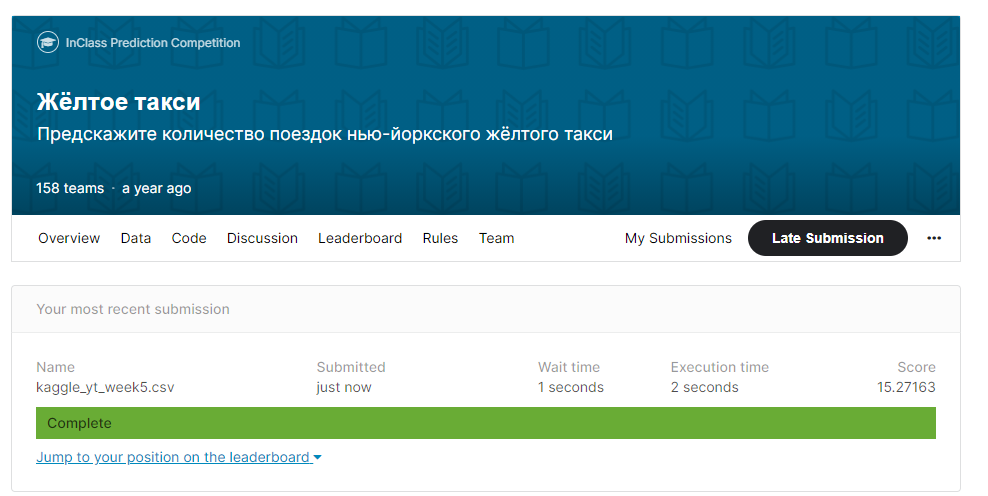